# Imports

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares
import iminuit
import os
from tqdm import tqdm
import seaborn as sns
import fssa

print("Iminuit version:", iminuit.__version__)

def power_law(x, a, b):
    return a * x ** b

def linear(x, a, b):
    return a + x * b


Iminuit version: 2.31.3


# Setup

Plotting density-spanning_cluster_size.dat...


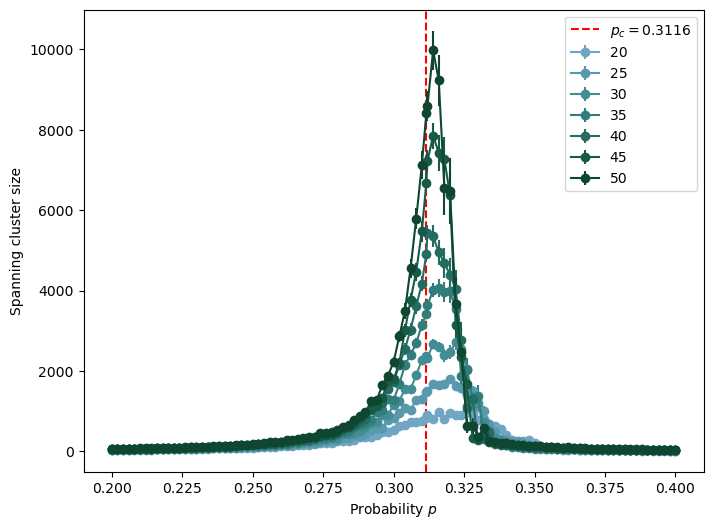

In [118]:
directories = ['20/export', '25/export', '30/export', '35/export', '40/export', '45/export', '50/export']
files = [
    'density-average_cluster_size.dat',
    'density-correlation_length.dat',
    'density-order_parameter.dat',
    'density-spanning_cluster_size.dat'
]
key = 3
filename = files[key]
print(f'Plotting {filename}...')

Label = filename.split('-')[1]
Label = Label.replace('_', ' ').replace('.dat', '').capitalize()

plt.figure(figsize=(8,6))
# Plot a line corresponding to the critical point p_c = 0.3116
plt.axvline(x=0.3116, color='red', linestyle='--', label=r'$p_c = 0.3116$')    

# Define colors
palette = sns.cubehelix_palette(
    n_colors=len(directories),  start=2.0, rot=0.35, gamma=1.0, hue=1.0, light=0.6, dark=0.2,
)
sns.set_palette(palette)

data = {}
for directory in directories:
    x, y, error = np.loadtxt(os.path.join(directory, filename), comments='#', unpack=True)
    label = directory.split('/')[0]
    plt.errorbar(x, y, yerr=error, fmt='o-', label=label)
    data[label] = [x, y, error]

keys = list(data.keys())
 
plt.xlabel(r'Probability $p$')
plt.ylabel(Label)
plt.legend()
plt.show()

# Scaling law at critical point

In [119]:


# Get p=0.3116 per system size
results = []
for i in range(len(data)):
    key = list(data.keys())[i]
    x, y, error = data[key]
    idx = (np.abs(x - 0.3116)).argmin()
    print()
    results.append([int(key), y[idx], error[idx]])
    

results = np.array(results)
results = results.T
for i in range(results.shape[1]):
    print(results[0][i], results[1][i], results[2][i])
    








20.0 829.59 26.03145
25.0 1480.055 46.03903
30.0 2383.63 72.27701
35.0 3416.555 114.73914
40.0 4906.03 145.38381
45.0 6678.125 210.13193
50.0 8404.62 279.05645


R² for power law fit: 0.9989
R² for log-log fit: 0.9989


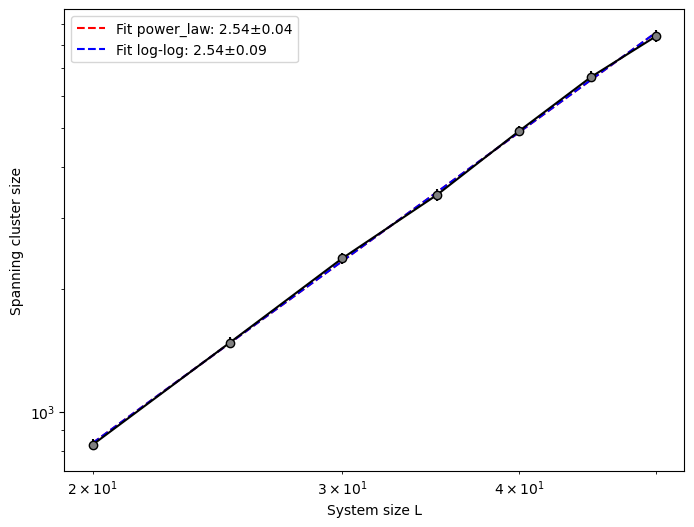

In [120]:
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(results[0], results[1], yerr=results[2], fmt='o-', color='k', mec='black', mfc='gray')

# Fit power law
cost = LeastSquares(results[0], results[1], results[2], power_law)
m = Minuit(cost, a=1, b=2)
m.migrad()
a_fit = m.values['a']
b_fit = m.values['b']
b_err = m.errors['b']
y_fit = power_law(results[0], a_fit, b_fit)
ax.plot(results[0], y_fit, 'r--', label=f'Fit power_law: {b_fit:.2f}±{b_err:.2f}')

# Compute R² for power law fit
ss_res = np.sum((results[1] - power_law(results[0], a_fit, b_fit))**2)
ss_tot = np.sum((results[1] - np.mean(results[1]))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f'R² for power law fit: {r_squared:.4f}')

# Fit linear in log-log
log_x = np.log10(results[0])
log_y = np.log10(results[1])
log_error = results[2] / results[1]  # Propagate error for log
cost_log = LeastSquares(log_x, log_y, log_error, linear)
m_log = Minuit(cost_log, a=1, b=2.5)
m_log.migrad()
a_log_fit = m_log.values['a']
b_log_fit = m_log.values['b']
b_log_err = m_log.errors['b']
y_log_fit = power_law(results[0], 10**a_log_fit, b_log_fit)

# Compute R² for log-log fit
ss_res = np.sum((log_y - (a_log_fit + b_log_fit * log_x))**2)
ss_tot = np.sum((log_y - np.mean(log_y))**2)
r_squared_loglog = 1 - (ss_res / ss_tot)
print(f'R² for log-log fit: {r_squared:.4f}')
ax.plot(results[0], y_log_fit, 'b--', label=f'Fit log-log: {b_log_fit:.2f}±{b_log_err:.2f}')

ax.set_xlabel('System size L')
ax.set_ylabel(Label)
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()
plt.show()

In [ ]:
if not os.path.exists('scaling_laws'):
    os.makedirs('scaling_laws')
with open(f'scaling_laws/fit-{filename.split('-')[1]}', 'w') as f:
    f.write(f'# Fit results for {Label}\n')
    f.write(f'# Power law fit: y = a * x^b\n')
    f.write(f'# a = {a_fit} ± {m.errors["a"]}\n')
    f.write(f'# b = {b_fit} ± {b_err}\n')
    f.write(f'# R² = {r_squared:.4f}\n')
    f.write(f'# Log-log fit: log(y) = a + b * log(x)\n')
    f.write(f'# a = {10^a_log_fit} ± {m_log.errors["a"]}\n')
    f.write(f'# b = {b_log_fit} ± {b_log_err}\n')
    f.write(f'# R² = {r_squared_loglog:.4f}\n')
    for i in range(len(results[0])):
        f.write(f'{results[0][i]} {results[1][i]} {results[2][i]}\n')

# Data collapse around the critical point

In [122]:
def find_argmin_without_zeros(arr):
    # make a copy of the array to avoid modifying the original
    arr_copy = arr.copy()
    # Replace zeros with a large value
    arr_copy[arr_copy == 0] = np.inf
    # Find the index of the minimum value
    argmin = np.argmin(arr_copy)
    return argmin


def find_argmax_without_ones(arr):
    # make a copy of the array to avoid modifying the original
    arr_copy = arr.copy()
    # Replace zeros with a large value
    arr_copy[arr_copy >= 0.99] = -np.inf
    # Find the index of the minimum value
    argmax = np.argmax(arr_copy)
    return argmax

# Define kawashima ito cost function
class KI:
    def __init__(self, title, l, rho, a, da, rho_c0, nu0, zeta0):
        self.title = title
        self.l = l
        self.rho = rho
        self.a = a
        self.da = da
        self.rho_c0 = rho_c0
        self.nu0 = nu0
        self.zeta0 = zeta0

    def __call__(self, rho_c, nu, zeta):
        a = self.a
        da = self.da
        l = self.l
        rho = self.rho
        this_x, this_y, this_dy = fssa.scaledata(
            l, rho, a, da, rho_c, nu, zeta)
        quality = fssa.quality(this_x, this_y, this_dy)
        return quality

    def visualize(self, args):
        if len(args) ==3:
            rho_c, nu, zeta  = args
        elif len(args) == 5:
            rho_c, nu, zeta, low_pc, up_pc = args
        else:
            raise ValueError("args must be of length 3 or 5")
        a = self.a
        da = self.da
        l = self.l
        rho = self.rho
        palette = sns.cubehelix_palette(
            n_colors=l.size, start=2.0, rot=0.35, gamma=1.0, hue=1.0, light=0.6, dark=0.2,
        )
        scaled_data = fssa.scaledata(l, rho, a, da, rho_c, nu, zeta)
        # plot
        max_scaled_y = np.max(scaled_data.y + scaled_data.dy)
        plt.plot([0, 0], [0, max_scaled_y], 'k--')

        for i in range(scaled_data.x.shape[0]):
            plt.errorbar(scaled_data.x[i, :], scaled_data.y[i, :], scaled_data.dy[i,
                            :], fmt='-o', color=palette[i], label=rf"$L$ = {l[i]}")
            
        refs = {
            'Average cluster size': 2.05,
            'Correlation length': 1.00,
            'Order parameter': -0.49,
            'Spanning cluster size': 2.51
        }
        titles = {
            'Average cluster size': r'$\langle S\rangle$',
            'Correlation length': r'$\xi$',
            'Order parameter': r'$P_\infty$',
            'Spanning cluster size': r'$S_\text{max}$'
        }
        plt.legend(title=titles.get(self.title, 'N/A')+'\n' +
                    rf"$\zeta/\nu$  = {zeta/nu:.2f}"+"\n ref = "+f"{refs.get(self.title, 'N/A')}")
        plt.text(
            0.01, 0.5, f"Quality = {fssa.quality(scaled_data.x, scaled_data.y, scaled_data.dy):.2f}", transform=plt.gca().transAxes)
        plt.text(
            0.01, 0.45, f"$\\rho_c$ = {rho_c:.2f}", transform=plt.gca().transAxes)
        plt.text(0.01, 0.40, f"$\\nu$ = {nu:.2f}",
                    transform=plt.gca().transAxes)
        plt.text(
            0.01, 0.35, f"$\\zeta$ = {zeta:.2f}", transform=plt.gca().transAxes)
        if len(args) == 5:
            plt.text(
                0.01, 0.30, rf"low $p$ = {low_pc:.2f}", transform=plt.gca().transAxes)
            plt.text(
                0.01, 0.25, rf"high $p$ = {up_pc:.2f}", transform=plt.gca().transAxes)
        if not os.path.exists('data_collapse'):
            os.makedirs('data_collapse')
        # plt.show()
        plt.savefig("data_collapse/"+self.title.replace(' ', '_') + '.png')
        # plt.close()
        
    def export_to_file(self, args):
        rho_c, nu, zeta = args
        a = self.a
        da = self.da
        l = self.l
        rho = self.rho
        scaled_data = fssa.scaledata(l, rho, a, da, rho_c, nu, zeta)
        if not os.path.exists('data_collapse'):
            os.makedirs('data_collapse')
        for i in range(scaled_data.x.shape[0]):
            np.savetxt("data_collapse/"+self.title.replace(' ', '_') + f"_L_{l[i]}.txt", np.array([scaled_data.x[i, :], scaled_data.y[i, :], scaled_data.dy[i,:]]).T)

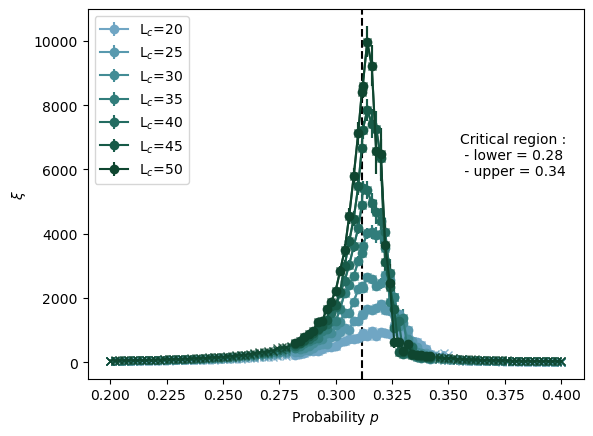

In [123]:
x = np.zeros((len(directories), len(data[keys[0]][0])))
y = np.zeros_like(x)
dy = np.zeros_like(x)
for i in range(len(directories)):
    key = list(data.keys())[i]
    x[i, :] = data[key][0]
    y[i, :] = data[key][1]
    dy[i, :] = data[key][2]

L = np.arange(20, 55, 5)

percent_up = 0.1
percent_low = 0.1
pc = 0.3116
low_pc = pc * (1 - percent_low)
up_pc = pc * (1 + percent_up)
argmin = find_argmin_without_zeros(x[0, :] - low_pc)
argmax = find_argmax_without_ones(x[0, :] - up_pc)

idx = np.where((x[0, :] >= low_pc) & (x[0, :] <= up_pc))[0]
x_cut = x[0, idx]
y_cut = np.zeros((len(directories), len(x_cut)))
dy_cut = np.zeros((len(directories), len(x_cut)))
for i in range(len(directories)):
    y_cut[i, :] = y[i, idx]
    dy_cut[i, :] = dy[i, idx]

# Non zero dy
dy_cut = np.where(dy_cut <=0, 1e-6, dy_cut)

# plot the interpolated data over the raw data
fig, ax = plt.subplots()
for i in range(len(directories)):
    x, y, dy = data[list(data.keys())[i]]
    ax.errorbar(x, y, dy, alpha=0.85, fmt='-x')
for i in range(len(directories)):
    ax.errorbar(x_cut, y_cut[i, :], dy_cut[i, :], fmt='-o', label=r'L$_c$='+str(L[i]))
ax.axvline(pc, color='k', linestyle='--')
ax.set_xlabel(r'Probability $p$')
ax.set_ylabel(r'$\xi$')
ax.text(0.75, 0.55, f'Critical region :\n - lower = {low_pc:.2f}\n - upper = {up_pc:.2f}', transform=ax.transAxes)
plt.legend()
plt.show()

In [124]:
rho_c = pc 
nu = 0.880
# zeta = 1.8
zetas = {
    'density-average_cluster_size.dat': 1.8,
    'density-correlation_length.dat': 1.0,
    'density-order_parameter.dat': -0.41,
    'density-spanning_cluster_size.dat': 2.2
}
zeta = zetas[filename]
title = filename.split('-')[1].split('.')[0].replace('_', ' ').capitalize()
cost = KI(title, L, x_cut, y_cut, dy_cut, rho_c, nu, zeta)
# limit the range of the parameters
m = Minuit(cost, rho_c, nu, zeta)
m.limits = [(0.31, 0.32), (0.5, 1.1), (-1.0, 2.5)]
m.interactive()

rho_c: 0.3116, nu: 0.8772, zeta: 2.2203, quality: 1.1927
errors: 0.0031, nu: 0.1816, zeta: 0.4969
rho_c: 0.3116, nu: 0.8772, zeta: 2.2203, quality: 1.1927
errors: 0.0031, nu: 0.1816, zeta: 0.4969
True


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.193                      │              Nfcn = 162              │
│ EDM = 0.00055 (Goal: 0.0002)     │            time = 0.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ rho_c │  0.3116   │  0.0031   │            │            │  0.31   │  0.32   │  yes  │
│ 1 │ nu    │   0.88    │   0.18    │            │            │  0.75   │    1    │       │
│ 2 │ zeta  │    2.2    │    0.5    │            │            │   -1    │   2.5   │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │ rho_c    nu  zeta │
├───────┼───────────────────┤
│ rho_c │     0  0.00  0.00 │
│    nu │  0.00 0.066  0.13 │
│  zeta │  0.00  0.13 0.271 │
└───────┴───────────────────┘

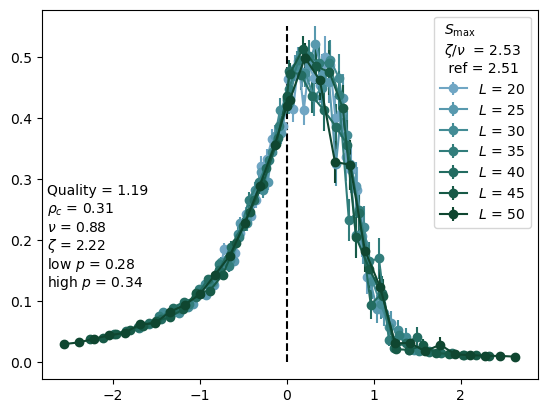

In [125]:
# limit the range of the parameters
m1 = Minuit(cost, rho_c, nu, zeta)
m1.limits = [(0.31, 0.32), (0.75, 1.0), (-1.0, 2.5)]
m1.fixed['rho_c'] = True
# m1.fixed['nu'] = True
# m1.fixed['zeta'] = True
# Run migrad until a valid minimum is found
while not m1.valid:
    m1.migrad(ncall=100000, iterate=50, use_simplex=False)
    m1.hesse()

    print(f"rho_c: {m1.values['rho_c']:.4f}, nu: {m1.values['nu']:.4f}, zeta: {m1.values['zeta']:.4f}, quality: {m1.fval:.4f}")
    print(f"errors: {m1.errors['rho_c']:.4f}, nu: {m1.errors['nu']:.4f}, zeta: {m1.errors['zeta']:.4f}")
    
    if not m1.valid:
        print("Invalid minimum. Retrying...")
        m1.values['rho_c'] = rho_c
        m1.values['nu'] = np.random.uniform(m1.limits[1][0], m1.limits[1][1])
        m1.values['zeta'] = np.random.uniform(m1.limits[2][0], m1.limits[2][1])

print(f"rho_c: {m1.values['rho_c']:.4f}, nu: {m1.values['nu']:.4f}, zeta: {m1.values['zeta']:.4f}, quality: {m1.fval:.4f}")
print(f"errors: {m1.errors['rho_c']:.4f}, nu: {m1.errors['nu']:.4f}, zeta: {m1.errors['zeta']:.4f}")
cost.visualize((m1.values['rho_c'], m1.values['nu'], m1.values['zeta'], low_pc, up_pc))
cost.export_to_file((m1.values['rho_c'], m1.values['nu'], m1.values['zeta']))
print(m1.valid)
m1.hesse()

# End